> **Copyright (c) 2020 Skymind Holdings Berhad**<br><br>
> **Copyright (c) 2021 Skymind Education Group Sdn. Bhd.**<br>
<br>
Licensed under the Apache License, Version 2.0 (the \"License\");
<br>you may not use this file except in compliance with the License.
<br>You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0/
<br>
<br>Unless required by applicable law or agreed to in writing, software
<br>distributed under the License is distributed on an \"AS IS\" BASIS,
<br>WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
<br>See the License for the specific language governing permissions and
<br>limitations under the License.
<br>
<br>
**SPDX-License-Identifier: Apache-2.0**
<br>

# Introduction

In this notebook, you will be learning few basic machine learning approaches few basic machine learning approaches in classifying tweet sentiment and how to run them in Python. Here, we focus on using machine learning approaches in solving sentiment analysis tasks.

<img src="../../../images/sentiment_analysis.jpg" alt="Sentiment Analysis" width=400>

# What will we accomplish?

By the end of this tutorial, you will know:

1. How to clean tweet data.


2. How to preprocess text data for training.


3. How to train Naïve Bayes and SVM algorithm.


4. How to use Shapely for model evaluation.

# Notebook Content

* [Sentiment Analysis](#Sentiment-Analysis)


* [Dataset](#Dataset)


* [Text Cleaning](#Text-Cleaning)

    * [Read Dataset](#Read-Dataset)
    * [Fixing Missing Values](#Fixing-Missing-Values)
    * [Rename Columns](#Rename-Columns)
    * [Abnormal Sentiment](#Abnormal-Sentiment)
    * [No Original Tweet](#No-Original-Tweet)
    * [Train-Test Split](#Train-Test-Split)
    
    
* [Preprocessing](#Preprocessing)
    
    * [Keep ASCII Characters Only](#Keep-ASCII-Characters-Only)
    * [Make All Lowercase](#Make-All-Lowercase)
    * [Remove Hyperlinks](#Remove-Hyperlinks)
    * [Remove HTML Symbols](#Remove-HTML-Symbols)
    * [Remove Mentions](#Remove-Mentions)
    * [Remove Unnecessary Punctuations](#Remove-Unnecessary-Punctuations)
    * [Remove Brand Words](#Remove-Brand-Words)
    * [Lemmatization & Removing Stopwords](#Lemmatization-&-Removing-Stopwords)
    * [Preprocessing Text](#Preprocessing-Text)


* [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))

    * [Negative vs Positive](#Negative-vs.-Positive)
    
    
* [Machine Learning Models](#Machine-Learning-Models)

    * [Naïve Bayes](#Naïve-Bayes)
    * [Support Vector Machine (SVM)](#Support-Vector-Machine-(SVM))
    * [Baseline Model](#Baseline-Model)
    * [Bag-of-Words Model (Count Vectors)](#Bag-of-Words-Model-(Count-Vectors))
        * [OverSampling](#OverSampling)
        * [Naïve Bayes](#Naïve-Bayes)
        * [SVM](#SVM)
    * [TF-IDF Score](#TF-IDF-Score)
        * [OverSampling](#OverSampling)
        * [Naïve Bayes](#Naïve-Bayes)
        * [SVM](#SVM)
        

* [Shapely Evaluation](#Shapely-Evaluation)

# Sentiment Analysis

**Sentiment analysis** is used to identify the affect or emotion (**positive**, **negative**, or **neutral**) of the data. For a business, it is a simple way to determine **customers’ reactions** towards the product or service and to quickly pick up on any change of emotion that may require immediate attention. The most basic approach to this problem is to use supervised learning. We can have actual humans to determine and label the sentiment of our data and treat it like a text classification problem. This is exactly what we will do in the up comming sections.

<img src="../../../images/sentiment_analysis.gif" alt="Sentiment Analysis" width=500>

# Dataset

The dataset that we are going to use is [Judge Emotion About Brands and Products](https://data.world/crowdflower/brands-and-product-emotions) retrieved from [data.world](https://data.world/). This dataset contains over 8000 tweets that have been labeled to be positive, negative, neutral, or unknown (“I can’t tell’). Dataset should be available at `datasets`folder, else you may download it [here](https://data.world/crowdflower/brands-and-product-emotions/workspace/file?filename=judge-1377884607_tweet_product_company.csv).

![Dataset Overview](../../../images/dataset.png)

# Text Cleaning

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import re

## Read Dataset

In [2]:
df = pd.read_csv('../../../resources/day_04/judge_tweet_product_company.csv', 
                 encoding='utf-8"',engine = 'python', encoding_errors='ignore')

In [3]:
df.head(3)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion


In [4]:
len(df)

9093

## Fixing Missing Values

In [5]:
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

We cannot infer a tweet so we'll remove the missing tweet_text.

In [6]:
df = df.dropna(subset = ['tweet_text'])

Whether the tweet is towards apple or google is post-tweet variable, so it isn't relevant for this problem. So we'll entirely removed this columns.

In [7]:
df = df.drop('emotion_in_tweet_is_directed_at', axis = 1)

## Rename Columns

We'll just make the columns a little bit easier to call out.

In [8]:
df.columns = ['tweet', 'sentiment']

In [9]:
df.head()

,tweet,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


## Abnormal Sentiment

Check if there's any abnormal sentiment.

In [10]:
df.sentiment.value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

`I can't tell` is not a valid classification. So we'll remove these.

In [11]:
df = df[df.sentiment != "I can't tell"]

## No Original Tweet

If the text only contains RT and not actual texts, we will be judging based on the previous tweet, so we should remove these.

In [12]:
# remove RT text
def remove_RT(text):
    return re.sub('(RT.+)', '', text)

In [13]:
df['tweet'] = df['tweet'].map(remove_RT)

In [14]:
df = df[df['tweet'] != '']

In [15]:
df.sentiment.value_counts()

No emotion toward brand or product    4133
Positive emotion                      2406
Negative emotion                       474
Name: sentiment, dtype: int64

In [16]:
print("Final length of the dataset:", len(df))

Final length of the dataset: 7013


## Train-Test Split

We'll divide the train/test split here so we can avoid any data leakage during preprocessing.

In [17]:
X = df['tweet']
y = df['sentiment']

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

We will also separate validation set out of train set.

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .2)

In [20]:
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Training set size: 4488
Validation set size: 1122
Test set size: 1403


# Preprocessing

After cleaning the data (removing observations with missing texts, removing 'unknown' class, removing RTs), and splitting our data into train, test, and validation sets, we need to preprocess texts so they are properly quantifiable for our analysis. We will go through them one by one.

From randomly sampled tweets, we will do at least the following: 

1. Find any links and remove them (e.g. bit.ly/g03MZB)


2. `@mention`, `{link}`
Create a feature that shows how many of these exists, but remove them from tokenization.


3. `[\w+]` seems to be emoji or pics/videos. keep them as is (with brackets) 


3. Word after # should be treated as a separate word than the same word without #, also count how many tags


4. `?&quot;`, `$amp;`, `�` should be removed.


5. ! and ? might be important to keep. count how many. 

## Import Libraries

In [21]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Keep ASCII Characters Only

Different encodings can result in some strange characters appearing on our data. So first we will make sure we are only keeping ASCII characters.

In [22]:
def ascii_only(text):
    return text.encode("ascii", "ignore").decode()

## Make All Lowercase

In [23]:
def make_lower(text):
    return text.lower()

## Remove Hyperlinks

In [24]:
# Find links and remove them

def remove_links(text):
    p = '((http\w*:\/\/)?(www\.\w+)?(\w+\.(com|co|ly|ch|org|net)+)(\/\w+)?)'
    return re.sub(p, ' ', text)

## Remove HTML Symbols

In [25]:
# Remove html symbol
def remove_html(text):
    return re.sub("[^A-Za-z0-9 ]\w+", ' ', text)

## Remove Mentions

In [26]:
# Remove mentions
def remove_mentions(text):
    return re.sub("(@\w*)", ' ', text)

## Remove Unnecessary Punctuations

Another straightforward cleaning. Please note, that we removing all punctuation here for the sake of simplicity, but in reality, many tweets may use punctuations to express the sentiment, such as :) and :(.

In [27]:
# Remove unnecessary punctuations
import string
punctuations = string.punctuation
punctuations = punctuations + '�' + string.digits

def remove_punctuations(text, punctuations):
    table_ = str.maketrans('', '', punctuations)
    return text.translate(table_) 

## Remove Brand Words

This is a step specific to this dataset. Because our dataset contains tweets about products, there’s a lot of references to the actual brand and product names. We don’t want the overall distribution of sentiment per different brands or products to bias our model, so we will remove some of them.

In [28]:
def remove_brandwords(text):
    p = '''#?(iphone|ipad|sxsw|hcsm|google|apple|cisco|austin|
    atari|intel|mac|pc|blackberry|android|linux|ubuntu)[a-z0-9]*'''
    return re.sub(p, ' ', text)

## Lemmatization & Removing Stopwords

Finally, we will lemmatize our vocabularies and remove stopwords using NLTK. In summary, lemmatizer will return the vocabularies into its basic form, lemma.

<img src="../../../images/lemma.png" alt="Sentiment Analysis" width=500>

In [29]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

sw = stopwords.words('english')

def lemmatize(x, sw):
    wnl = WordNetLemmatizer()
    return ' '.join([wnl.lemmatize(w) for w in x.split() if w not in sw])

## Preprocessing Text

In [30]:
def preprocessing(df, punctuations, stopwords):
    df['tweet'] = df.tweet.apply(lambda x: ascii_only(x))
    df['tweet'] = df.tweet.apply(lambda x: make_lower(x))
    df['tweet'] = df.tweet.apply(lambda x: remove_links(x))
    df['tweet'] = df.tweet.apply(lambda x: remove_html(x))
    df['tweet'] = df.tweet.apply(lambda x: remove_mentions(x))
    df['tweet'] = df.tweet.apply(lambda x: remove_punctuations(x, punctuations))
    df['tweet'] = df.tweet.apply(lambda x: remove_brandwords(x))
    df['tweet'] = df.tweet.apply(lambda x: lemmatize(x, sw))
    
    return df

In [31]:
X_train_pp = preprocessing(pd.DataFrame(X_train), punctuations, sw)
X_val_pp = preprocessing(pd.DataFrame(X_val), punctuations, sw)
X_test_pp = preprocessing(pd.DataFrame(X_test), punctuations, sw)

# Exploratory Data Analysis (EDA)

In [32]:
# Combining with target value
train_pp = X_train_pp.join(y_train)

In [33]:
train_pp

,tweet,sentiment
3362,great stuff fri marissa mayer tim book matt mu...,Positive emotion
1306,better,Negative emotion
619,hello enjoy ride anywhere download app booth,Positive emotion
1833,really great experience user month highly reco...,Positive emotion
2212,marissa mayer speaking mobile phone usage map ...,Positive emotion
...,...,...
3217,best thing abt bad as brunch w plenty free par...,No emotion toward brand or product
3503,gone yellow cab minivan anyone happens get yel...,No emotion toward brand or product
998,pepsi max marketing street team shown popup st...,No emotion toward brand or product
3074,yet line store going well around block,No emotion toward brand or product


In [34]:
# Now tokenize and Remove stopwords
def tokenize(text, stopwords):
    return [x for x in word_tokenize(text) if x not in stopwords]

In [35]:
train_pp['tweet'] = train_pp.tweet.apply(lambda x: tokenize(x, sw))

## Negative vs. Positive

In [36]:
train_pp.sentiment.value_counts()

No emotion toward brand or product    2644
Positive emotion                      1527
Negative emotion                       317
Name: sentiment, dtype: int64

In [37]:
neg_texts = train_pp[train_pp.sentiment == 'Negative emotion']['tweet']
pos_texts = train_pp[train_pp.sentiment == 'Positive emotion']['tweet']
neu_texts = train_pp[train_pp.sentiment == 'No emotion toward brand or product']['tweet']

In [38]:
neg_text = np.sum(neg_texts)
pos_text = np.sum(pos_texts)
neu_text = np.sum(neu_texts)

In [39]:
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [40]:
top30_neg = dict(Counter(neg_text).most_common(30))
top30_pos = dict(Counter(pos_text).most_common(30))

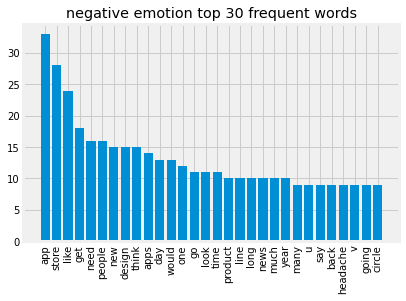

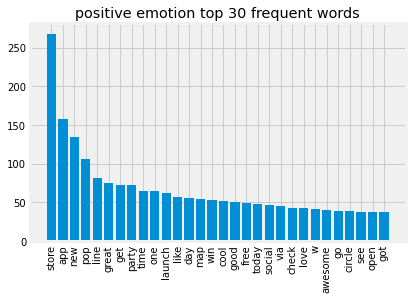

In [41]:
plt.bar(top30_neg.keys(), top30_neg.values())
plt.xticks(rotation = 90)
plt.title('negative emotion top 30 frequent words')
plt.show()

plt.bar(top30_pos.keys(), top30_pos.values())
plt.xticks(rotation = 90)
plt.title('positive emotion top 30 frequent words')
plt.show()

# Machine Learning Models

## Naïve Bayes

**Naïve Bayes** is one of the more popular choices for text classification. It’s a simple application of **Bayes Theorem** on each class and the predictors, and it assumes that each individual features (words in our case) are independent of each other.

So let’s say, we have a tweet that reads… “I love my new phone. It’s really fast, reliable and well-designed!”. This tweet clearly has a positive sentiment. In this case, the Naive-Bayes model assumes that the individual words like ‘love’, ‘new’, ‘really’, ‘fast’, ‘reliable’, all contribute independently to its positive class. In other words, likelihood of the tweet being positive when it uses the word ‘reliable’ does not change by other words. This does not mean that these words are independent in their appearances. Some words may tend to appear together more often than not, but that does not mean how much each word contributes to its class is dependent.

Naïve Bayes algorithm is simple to use and reliable when the above assumption holds. Since testing on our model requires vectorization, we can get the pipeline built into our model.

## Support Vector Machine (SVM)

Another popular choice of the text classification algorithm is the support vector machine (SVM). Simply put, SVM finds the hyperplane that divides the classes with a maximum margin between them. The main reason SVM is preferred in text classification is that we tend to end up with a lot of features. If we were to work in such a high dimensional space that takes all our features, it would have caused a problem known as the curse of dimensionality. 

Basically, our space is too big that our observations start to lose their meanings. But SVM is more robust when dealing with a large number of features because it uses the kernel trick. SVM does not actually work in the high dimensions, it just looks at the pairwise distances between observations as if they are in the high dimensions. It does take a long time to do the job, but it is robust.

## Import Libraries

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

from timeit import default_timer as timer
from custom_functions import clean_up, evaluating, scoring, get_pred

In [43]:
X_train = X_train_pp
X_test = X_test_pp

## Baseline Model

We can use a scikit-learn’s `DummyClassifier` to first see what our baseline measure would be if we were to just classify it based on how frequently each class occurs.

In [44]:
from sklearn.dummy import DummyClassifier

In [45]:
dummyc = DummyClassifier()
dummyc.fit(X_train['tweet'], y_train)

DummyClassifier()

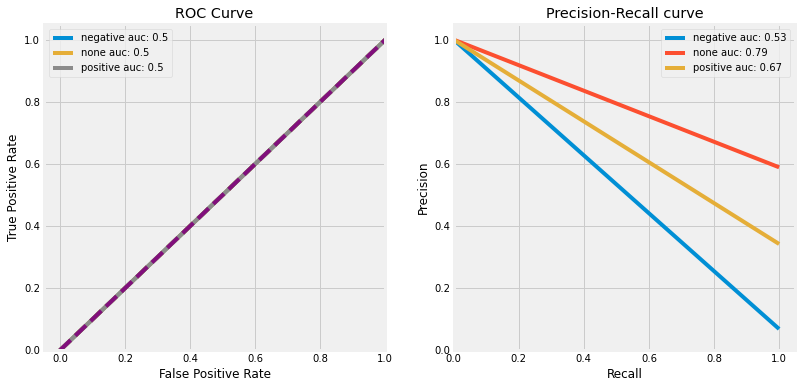

accuracy score:  0.5891 cohens kappa:  0.0
                                    precision    recall  f1-score   support

                  Negative emotion       0.00      0.00      0.00        77
No emotion toward brand or product       0.59      1.00      0.74       661
                  Positive emotion       0.00      0.00      0.00       384

                          accuracy                           0.59      1122
                         macro avg       0.20      0.33      0.25      1122
                      weighted avg       0.35      0.59      0.44      1122



In [46]:
y_pred, y_pred_p = get_pred(dummyc, X_val)
evaluating(y_val, y_pred, y_pred_p)

## Bag-of-Words Model (Count Vectors)

One of the simplest way to quantify text data is to just count the frequency of each word. The scikit-learn’s `CountVectorizer` can do that job easily.

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

countvec = CountVectorizer(ngram_range = (1, 2), min_df = 2, max_df = 4000)
X_train_count = countvec.fit_transform(X_train.tweet)

This returns the count vectors of single vocabularies and bigrams that occurs at least twice. Then we can use thes count vectors to train different classification algorithms.

### OverSampling

Currently our dataset has a class imbalance issue. I'll first try to resolve this by oversampling using SMOTE.

In [48]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(n_jobs = 3, random_state=22)
X_train_count, y_train_count = smote.fit_resample(X_train_count, y_train)

### Naïve Bayes

In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, auc, roc_curve, precision_recall_curve

mn_nb = MultinomialNB()
model = Pipeline([('vectorize', countvec), ('classify', mn_nb)])
model['classify'].fit(X_train_count, y_train_count)

MultinomialNB()

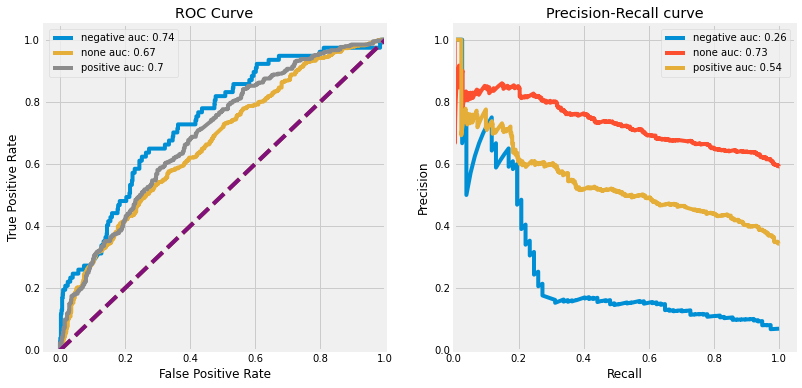

accuracy score:  0.5579 cohens kappa:  0.2229
                                    precision    recall  f1-score   support

                  Negative emotion       0.19      0.30      0.23        77
No emotion toward brand or product       0.70      0.57      0.63       661
                  Positive emotion       0.49      0.59      0.53       384

                          accuracy                           0.56      1122
                         macro avg       0.46      0.49      0.47      1122
                      weighted avg       0.59      0.56      0.57      1122



In [50]:
y_pred, y_pred_p = get_pred(model, X_val)
evaluating(y_val, y_pred, y_pred_p)

Performance is not quite optimal. Especially predicting negative emotion is very bad. Less than 35% of true cases were detected, and even with the ones predicted they were mostly wrong.

### SVM

In [51]:
import optuna
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC

In [52]:
def find_hyperparam_svm(trial):
    C = trial.suggest_loguniform('C', 0.001, 1)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    tol = trial.suggest_loguniform('tol', 0.001, 0.1)
    svc = SVC(probability = True, 
              C = C,
              gamma = gamma,
              tol = tol,
              class_weight = 'balanced'
             )
    cv = KFold(n_splits = 7, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(svc, X_train_count, y_train_count,
                                    scoring = 'f1_macro', cv = cv, n_jobs = -1))
    return (score)

# svm_study = optuna.create_study(direction='maximize')
# svm_study.optimize(find_hyperparam_svm, timeout = 600)

In [53]:
best_params = {'C': 0.9940853222932682, 'gamma': 'scale', 'tol': 0.00696902871883926}
# best_params = svm_study.best_params

print(best_params)

{'C': 0.9940853222932682, 'gamma': 'scale', 'tol': 0.00696902871883926}


In [54]:
svm = SVC(class_weight = 'balanced', 
           **best_params, 
           probability= True)

svm.fit(X_train_count, y_train_count)

SVC(C=0.9940853222932682, class_weight='balanced', probability=True,
    tol=0.00696902871883926)

In [55]:
X_val_count = countvec.transform(X_val)

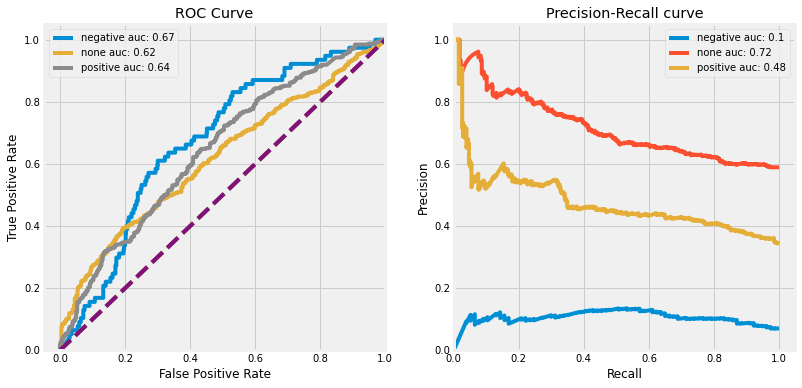

accuracy score:  0.557 cohens kappa:  0.1199
                                    precision    recall  f1-score   support

                  Negative emotion       0.10      0.16      0.12        77
No emotion toward brand or product       0.63      0.79      0.70       661
                  Positive emotion       0.53      0.23      0.32       384

                          accuracy                           0.56      1122
                         macro avg       0.42      0.39      0.38      1122
                      weighted avg       0.56      0.56      0.53      1122



In [56]:
y_pred, y_pred_p = get_pred(svm, X_val_count)
evaluating(y_val, y_pred, y_pred_p)

## TF-IDF Score

A problem with the count vector is that it only looks at the frequency of individual word and it does not care about the context in which the word occurs. There’s no way to assess whether how important specific word in a tweet is. This is where the term frequency — inverse document frequency (TF-IDF) score comes in. TF-IDF score weighs words that are more uniquely frequent in one tweet more than words that tend to be frequent across all tweets.

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vectorizer = TfidfVectorizer(ngram_range = (1, 2), min_df = 2, max_features= 4000)
                                
X_train_tf = tf_vectorizer.fit_transform(X_train.tweet)

### OverSampling

In [58]:
smote = SMOTE(n_jobs = 3, random_state=22)
X_train_tf_r, y_train_tf_r = smote.fit_resample(X_train_tf, y_train)

### Naïve Bayes

In [59]:
# Native-bayes
mn_nb = MultinomialNB()
model = Pipeline([('vectorize', tf_vectorizer), ('classify', mn_nb)])
model['classify'].fit(X_train_tf_r, y_train_tf_r)

MultinomialNB()

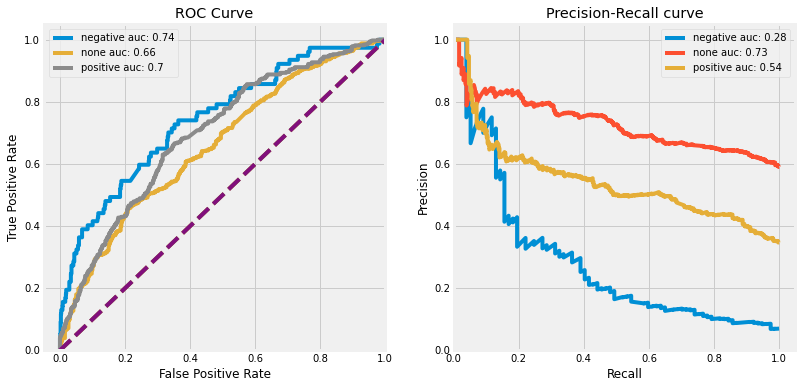

accuracy score:  0.5365 cohens kappa:  0.2197
                                    precision    recall  f1-score   support

                  Negative emotion       0.17      0.51      0.25        77
No emotion toward brand or product       0.70      0.58      0.63       661
                  Positive emotion       0.52      0.47      0.49       384

                          accuracy                           0.54      1122
                         macro avg       0.46      0.52      0.46      1122
                      weighted avg       0.60      0.54      0.56      1122



In [60]:
y_pred, y_pred_p = get_pred(model, X_val)
evaluating(y_val, y_pred, y_pred_p)

The overall accuracy is not great, but at least this does a better job at catching all three classes about 50% correctly. It seems like it's falsely biasing towards minority class though. Overall bias is high.

### SVM

In [61]:
def find_hyperparam_svm(trial):
    C = trial.suggest_loguniform('C', 0.001, 1)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    tol = trial.suggest_loguniform('tol', 0.001, 0.1)
    svc = SVC(probability = True, 
              C = C,
              gamma = gamma,
              tol = tol,
              class_weight = 'balanced'
             )
    cv = KFold(n_splits = 7, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(svc, X_train_tf, y_train,
                                    scoring = 'f1_macro', cv = cv, n_jobs = -1))
    return (score)

# svm_study1 = optuna.create_study(direction='maximize')
# svm_study1.optimize(find_hyperparam_svm, timeout = 600)

In [62]:
best_params = {'C': 0.7504169568132697, 'gamma': 'scale', 'tol': 0.03759088083379054}
# best_params = svm_study1.best_params

print(best_params)

{'C': 0.7504169568132697, 'gamma': 'scale', 'tol': 0.03759088083379054}


In [63]:
svm1 = SVC(class_weight = 'balanced', 
           **best_params,
           probability= True)

svm1.fit(X_train_tf, y_train)

SVC(C=0.7504169568132697, class_weight='balanced', probability=True,
    tol=0.03759088083379054)

In [64]:
X_val_tf = tf_vectorizer.transform(X_val)

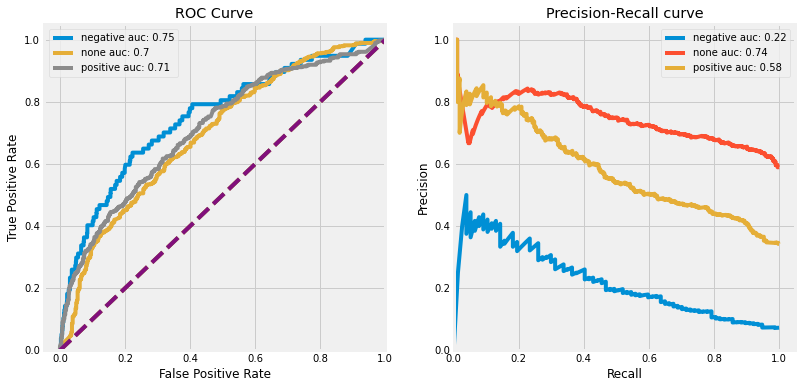

accuracy score:  0.6364 cohens kappa:  0.2668
                                    precision    recall  f1-score   support

                  Negative emotion       0.42      0.14      0.21        77
No emotion toward brand or product       0.68      0.78      0.73       661
                  Positive emotion       0.56      0.48      0.52       384

                          accuracy                           0.64      1122
                         macro avg       0.55      0.47      0.49      1122
                      weighted avg       0.62      0.64      0.62      1122



In [65]:
y_pred, y_pred_p = get_pred(svm1,X_val_tf)
evaluating(y_val, y_pred, y_pred_p)

No overfitting. But prediction of minority class is consistently bad.

# Shapely Evaluation

When the SVM uses the kernel trick, things get into a bit of grey area, in terms of interpretability. But we can use the Shapley value to decipher how individual features are contributing to the classification. We’ll use SHAP’s friendly interface to visualize the Shapley values.

In [66]:
import shap

In [67]:
shap.initjs()

In [68]:
sample = shap.kmeans(X_train_tf, 10)
e = shap.KernelExplainer(svm1.predict_proba, sample, link = 'logit')

In [69]:
shap_vals = e.shap_values(X_val_tf, nsamples = 100)

  0%|          | 0/1122 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=3.639e-05, with an active set of 21 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 62 iterations, i.e. alpha=7.212e-07, with an active set of 42 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 63 iterations, alpha=6.940e-07, previous alpha=4.954e-07, with an active set of 42 regressors.
Regressors in active set degenerate. Dropping a regressor, after 42 iterations, i.e. alpha=4.736e-06, with an active set of 34 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the curr

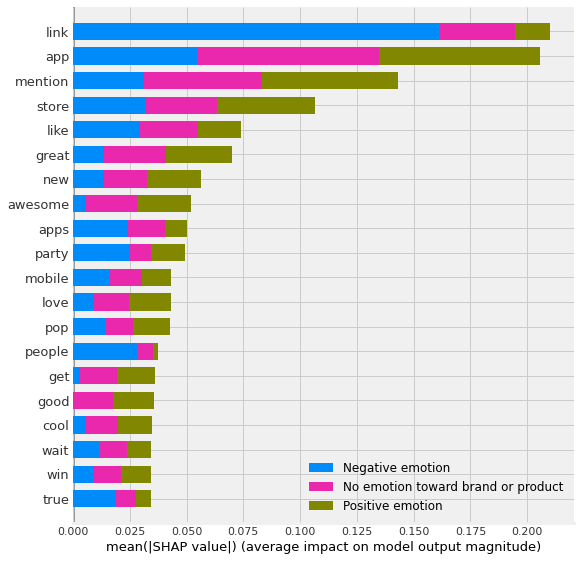

In [70]:
shap.summary_plot(shap_vals, feature_names = tf_vectorizer.get_feature_names(), class_names = svm1.classes_)

# Contributors

**Author**
<br>Chee Lam

# References

1. [Fundamentals of Supervised Sentiment Analysis](https://towardsdatascience.com/fundamentals-of-supervised-sentiment-analysis-1975b5b54108)